In [1]:
from modules.data import *

#import_csv("Neighborhood_zhvi_uc_condo_tier_0.33_0.67_sm_sa_mon.csv")


In [2]:
from modules.util import *

row1 = [
    112345,
    1,
    "Maryvale",
    "Neighborhood",
    "AZ",
    "AZ",
    "Phoenix",
    "Phoenix-Mesa-Scottsdale",
    "Maricopa County",
    "Condo",
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    37276,
    37460,
    37651,
    37952,
    38058,
    38147,
    38109,
    38101,
    38184,
    38647,
    39093,
    39520,
    39890,
    40411,
    40858,
    41117,
    41665,
    42387,
    43414,
    44525,
    45639,
    46056,
    46411,
    46702,
    47441,
    47927,
    48281,
    49026,
    49871,
    50543,
    51076,
    51435,
    51483,
    51701,
    52193,
    52892,
    52940,
    52706,
    52794,
    52991,
    53153,
    53272,
    53428,
    53594,
    54006,
    54499,
    54801,
    55224,
    55944,
    56879,
    57753,
    58391,
    58915,
    59221,
    59345,
    59918,
    60661,
    61593,
    62591,
    63113,
    63592,
    63920,
    64207,
    64466,
    64589,
    65087,
    65768,
    66390,
    66961,
    67279,
    67605,
    68135,
    68847,
    69765,
    70857,
    72287,
    73806,
    75221,
    76507,
    77530,
    78662,
    79761,
    81170,
    82412,
    83356,
    84237,
    85176,
    85970,
    86866,
    87708,
    88988,
    90375,
    91210,
    91957,
    92161,
    92813,
    93466,
    94187,
    95161,
    96678,
    98149,
    98918,
    98935,
    99229,
    100026,
    101035,
    101836,
    102872,
    104085,
    105594,
    106656,
    107366,
    108152,
    109696,
    111776,
    113775,
    115787,
    117832,
    120451,
    122818
  ]

header = [
    "RegionID",
    "SizeRank",
    "RegionName",
    "RegionType",
    "StateName",
    "State",
    "City",
    "Metro",
    "CountyName",
    "1996-01-31",
    "1996-02-29",
    "1996-03-31",
    "1996-04-30",
    "1996-05-31",
    "1996-06-30",
    "1996-07-31",
    "1996-08-31",
    "1996-09-30",
    "1996-10-31",
    "1996-11-30",
    "1996-12-31",
    "1997-01-31",
    "1997-02-28",
    "1997-03-31",
    "1997-04-30",
    "1997-05-31",
    "1997-06-30",
    "1997-07-31",
    "1997-08-31",
    "1997-09-30",
    "1997-10-31",
    "1997-11-30",
    "1997-12-31",
    "1998-01-31",
    "1998-02-28",
    "1998-03-31",
    "1998-04-30",
    "1998-05-31",
    "1998-06-30",
    "1998-07-31",
    "1998-08-31",
    "1998-09-30",
    "1998-10-31",
    "1998-11-30",
    "1998-12-31",
    "1999-01-31",
    "1999-02-28",
    "1999-03-31",
    "1999-04-30",
    "1999-05-31",
    "1999-06-30",
    "1999-07-31",
    "1999-08-31",
    "1999-09-30",
    "1999-10-31",
    "1999-11-30",
    "1999-12-31",
    "2000-01-31",
    "2000-02-29",
    "2000-03-31",
    "2000-04-30",
    "2000-05-31",
    "2000-06-30",
    "2000-07-31",
    "2000-08-31",
    "2000-09-30",
    "2000-10-31",
    "2000-11-30",
    "2000-12-31",
    "2001-01-31",
    "2001-02-28",
    "2001-03-31",
    "2001-04-30",
    "2001-05-31",
    "2001-06-30",
    "2001-07-31",
    "2001-08-31",
    "2001-09-30",
    "2001-10-31",
    "2001-11-30",
    "2001-12-31",
    "2002-01-31",
    "2002-02-28",
    "2002-03-31",
    "2002-04-30",
    "2002-05-31",
    "2002-06-30",
    "2002-07-31",
    "2002-08-31",
    "2002-09-30",
    "2002-10-31",
    "2002-11-30",
    "2002-12-31",
    "2003-01-31",
    "2003-02-28",
    "2003-03-31",
    "2003-04-30",
    "2003-05-31",
    "2003-06-30",
    "2003-07-31",
    "2003-08-31",
    "2003-09-30",
    "2003-10-31",
    "2003-11-30",
    "2003-12-31",
    "2004-01-31",
    "2004-02-29",
    "2004-03-31",
    "2004-04-30",
    "2004-05-31",
    "2004-06-30",
    "2004-07-31",
    "2004-08-31",
    "2004-09-30",
    "2004-10-31",
    "2004-11-30",
    "2004-12-31",
    "2005-01-31",
    "2005-02-28",
    "2005-03-31",
    "2005-04-30",
    "2005-05-31",
    "2005-06-30",
    "2005-07-31",
    "2005-08-31",
    "2005-09-30",
    "2005-10-31",
    "2005-11-30",
    "2005-12-31",
    "2006-01-31",
    "2006-02-28",
    "2006-03-31",
    "2006-04-30",
    "2006-05-31",
    "2006-06-30",
    "2006-07-31",
    "2006-08-31",
    "2006-09-30",
    "2006-10-31",
    "2006-11-30",
    "2006-12-31",
    "2007-01-31",
    "2007-02-28",
    "2007-03-31",
    "2007-04-30",
    "2007-05-31",
    "2007-06-30",
    "2007-07-31",
    "2007-08-31",
    "2007-09-30",
    "2007-10-31",
    "2007-11-30",
    "2007-12-31",
    "2008-01-31",
    "2008-02-29",
    "2008-03-31",
    "2008-04-30",
    "2008-05-31",
    "2008-06-30",
    "2008-07-31",
    "2008-08-31",
    "2008-09-30",
    "2008-10-31",
    "2008-11-30",
    "2008-12-31",
    "2009-01-31",
    "2009-02-28",
    "2009-03-31",
    "2009-04-30",
    "2009-05-31",
    "2009-06-30",
    "2009-07-31",
    "2009-08-31",
    "2009-09-30",
    "2009-10-31",
    "2009-11-30",
    "2009-12-31",
    "2010-01-31",
    "2010-02-28",
    "2010-03-31",
    "2010-04-30",
    "2010-05-31",
    "2010-06-30",
    "2010-07-31",
    "2010-08-31",
    "2010-09-30",
    "2010-10-31",
    "2010-11-30",
    "2010-12-31",
    "2011-01-31",
    "2011-02-28",
    "2011-03-31",
    "2011-04-30",
    "2011-05-31",
    "2011-06-30",
    "2011-07-31",
    "2011-08-31",
    "2011-09-30",
    "2011-10-31",
    "2011-11-30",
    "2011-12-31",
    "2012-01-31",
    "2012-02-29",
    "2012-03-31",
    "2012-04-30",
    "2012-05-31",
    "2012-06-30",
    "2012-07-31",
    "2012-08-31",
    "2012-09-30",
    "2012-10-31",
    "2012-11-30",
    "2012-12-31",
    "2013-01-31",
    "2013-02-28",
    "2013-03-31",
    "2013-04-30",
    "2013-05-31",
    "2013-06-30",
    "2013-07-31",
    "2013-08-31",
    "2013-09-30",
    "2013-10-31",
    "2013-11-30",
    "2013-12-31",
    "2014-01-31",
    "2014-02-28",
    "2014-03-31",
    "2014-04-30",
    "2014-05-31",
    "2014-06-30",
    "2014-07-31",
    "2014-08-31",
    "2014-09-30",
    "2014-10-31",
    "2014-11-30",
    "2014-12-31",
    "2015-01-31",
    "2015-02-28",
    "2015-03-31",
    "2015-04-30",
    "2015-05-31",
    "2015-06-30",
    "2015-07-31",
    "2015-08-31",
    "2015-09-30",
    "2015-10-31",
    "2015-11-30",
    "2015-12-31",
    "2016-01-31",
    "2016-02-29",
    "2016-03-31",
    "2016-04-30",
    "2016-05-31",
    "2016-06-30",
    "2016-07-31",
    "2016-08-31",
    "2016-09-30",
    "2016-10-31",
    "2016-11-30",
    "2016-12-31",
    "2017-01-31",
    "2017-02-28",
    "2017-03-31",
    "2017-04-30",
    "2017-05-31",
    "2017-06-30",
    "2017-07-31",
    "2017-08-31",
    "2017-09-30",
    "2017-10-31",
    "2017-11-30",
    "2017-12-31",
    "2018-01-31",
    "2018-02-28",
    "2018-03-31",
    "2018-04-30",
    "2018-05-31",
    "2018-06-30",
    "2018-07-31",
    "2018-08-31",
    "2018-09-30",
    "2018-10-31",
    "2018-11-30",
    "2018-12-31",
    "2019-01-31",
    "2019-02-28",
    "2019-03-31",
    "2019-04-30",
    "2019-05-31",
    "2019-06-30",
    "2019-07-31",
    "2019-08-31",
    "2019-09-30",
    "2019-10-31",
    "2019-11-30",
    "2019-12-31",
    "2020-01-31",
    "2020-02-29",
    "2020-03-31",
    "2020-04-30",
    "2020-05-31",
    "2020-06-30",
    "2020-07-31",
    "2020-08-31",
    "2020-09-30",
    "2020-10-31",
    "2020-11-30",
    "2020-12-31",
    "2021-01-31",
    "2021-02-28"
  ]

def inflate_zillow_row_by_date(row, header):
    """
    inflate_zillow_row_by_date inflates a single zillow row into multiple rows by date to create a long table from a wide table
    :param row: data from zillow row to be normalised
    :param header: row header columns
    :return: list of inflated rows
    """
    inflated_rows = []
    # +1 for addition of custom_column_housing_type in normalise_zillow_row, +1 for exclusive range and inclusive slice
    county_name_index = zillow_named_column_indexes.index(zillow_column_county_name) + 1
    common_row_metadata = row[:county_name_index]  # everything to housing type is common
    for index in range(county_name_index, len(header)):
        common_copy = copy.deepcopy(common_row_metadata)
        converted_header_to_timestamp = str(pd.to_datetime(header[index]))
        common_copy.append(converted_header_to_timestamp)  # add header date
        common_copy.append(row[index])  # housing value at date
        inflated_rows.append(common_copy)
    return inflated_rows

inflate_zillow_row_by_date(row1, header)


[[112345,
  1,
  'Maryvale',
  'Neighborhood',
  'AZ',
  'AZ',
  'Phoenix',
  'Phoenix-Mesa-Scottsdale',
  'Maricopa County',
  '1996-01-31 00:00:00',
  'Condo'],
 [112345,
  1,
  'Maryvale',
  'Neighborhood',
  'AZ',
  'AZ',
  'Phoenix',
  'Phoenix-Mesa-Scottsdale',
  'Maricopa County',
  '1996-02-29 00:00:00',
  0],
 [112345,
  1,
  'Maryvale',
  'Neighborhood',
  'AZ',
  'AZ',
  'Phoenix',
  'Phoenix-Mesa-Scottsdale',
  'Maricopa County',
  '1996-03-31 00:00:00',
  0],
 [112345,
  1,
  'Maryvale',
  'Neighborhood',
  'AZ',
  'AZ',
  'Phoenix',
  'Phoenix-Mesa-Scottsdale',
  'Maricopa County',
  '1996-04-30 00:00:00',
  0],
 [112345,
  1,
  'Maryvale',
  'Neighborhood',
  'AZ',
  'AZ',
  'Phoenix',
  'Phoenix-Mesa-Scottsdale',
  'Maricopa County',
  '1996-05-31 00:00:00',
  0],
 [112345,
  1,
  'Maryvale',
  'Neighborhood',
  'AZ',
  'AZ',
  'Phoenix',
  'Phoenix-Mesa-Scottsdale',
  'Maricopa County',
  '1996-06-30 00:00:00',
  0],
 [112345,
  1,
  'Maryvale',
  'Neighborhood',
  'AZ

In [202]:
data = import_csv("ingested_condo.csv")

In [203]:
import pandas as pd
import numpy as np
import copy

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

copydata = copy.deepcopy(data)

columns = copydata.pop(0)
df1 = pd.DataFrame(copydata, columns=columns) # import into dataframe from database

# temp while reading from file
df1['ZHVI'] = df1['ZHVI'].astype(float)

df1["Date"] = pd.to_datetime(df1["Date"]) # convert to pandas date
df1['ZHVI'] = df1['ZHVI'].replace([0], np.nan) # replace zero ZHVI with NAN to exclude from calculations
df1.sort_values(by=['Date']) # sorting the data allows for percent change to be calculated correctly

# todo, maybe delete pct_change
df1['% Change'] = df1.groupby(['RegionName'])['ZHVI'].pct_change()*100

df1.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Housing Type,Date,ZHVI,% Change
0,274772,0,Northeast Dallas,Neighborhood,TX,TX,Dallas,Dallas-Fort Worth-Arlington,Dallas County,Condo,1996-01-31,NaN,NaN
1,274772,0,Northeast Dallas,Neighborhood,TX,TX,Dallas,Dallas-Fort Worth-Arlington,Dallas County,Condo,1996-02-29,NaN,NaN
2,274772,0,Northeast Dallas,Neighborhood,TX,TX,Dallas,Dallas-Fort Worth-Arlington,Dallas County,Condo,1996-03-31,NaN,NaN
3,274772,0,Northeast Dallas,Neighborhood,TX,TX,Dallas,Dallas-Fort Worth-Arlington,Dallas County,Condo,1996-04-30,NaN,NaN
4,274772,0,Northeast Dallas,Neighborhood,TX,TX,Dallas,Dallas-Fort Worth-Arlington,Dallas County,Condo,1996-05-31,NaN,NaN


<AxesSubplot:xlabel='Date'>

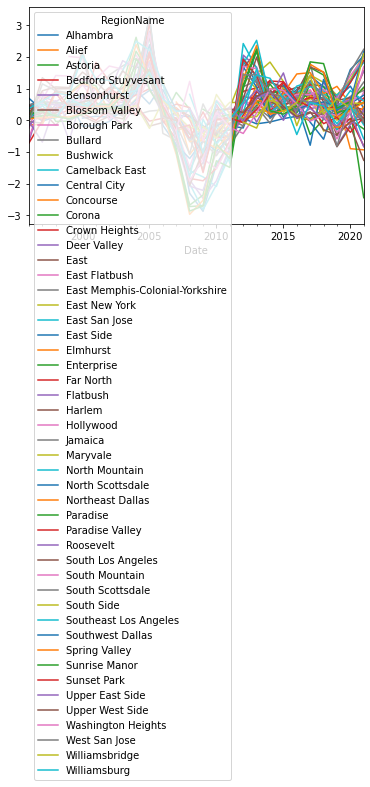

In [204]:

df2 = df1.pivot(index="Date", columns="RegionName", values="% Change")
df2 = df2.resample("Y").mean()
#df2.head()
df2.plot()

In [230]:
import locale
locale.setlocale( locale.LC_ALL, '')

def percent_formatter(value):
    return "{:.2f}%".format(value)

def currency_formatter(value):
    return "${}".format(locale.format_string('%d', value, True))

def currency_unformatter(value):
    return locale.atof(value.strip("$"))

# home appreciation formula
def get_home_appreciation_percentage_per_year(initial_value, final_value, years):
    # https://goodcalculators.com/home-appreciation-calculator/
    final_value = currency_unformatter(final_value)
    initial_value = currency_unformatter(initial_value)
    years = float(years)
    return (((final_value/initial_value)**(1/years))-1)*100


default_groupby = ["RegionName", "Housing Type"]

df3 = df1.copy(deep=True)
df3 = df3.set_index(default_groupby)

df3.tail()


RegionID SizeRank    RegionType StateName State  \
RegionName     Housing Type                                                   
Blossom Valley Condo          276215       51  Neighborhood        CA    CA   
               Condo          276215       51  Neighborhood        CA    CA   
               Condo          276215       51  Neighborhood        CA    CA   
               Condo          276215       51  Neighborhood        CA    CA   
               Condo          276215       51  Neighborhood        CA    CA   

                                 City                           Metro  \
RegionName     Housing Type                                             
Blossom Valley Condo         San Jose  San Jose-Sunnyvale-Santa Clara   
               Condo         San Jose  San Jose-Sunnyvale-Santa Clara   
               Condo         San Jose  San Jose-Sunnyvale-Santa Clara   
               Condo         San Jose  San Jose-Sunnyvale-Santa Clara   
               Condo         San Jose  San Jose-Sunnyvale-Santa Clara   

                                     CountyName       Date      ZHVI  % Change  
RegionName     Housing Type                                                     
Blossom Valley Condo         Santa Clara County 2020-10-31  578927.0  0.852213  
               Condo         Santa Clara County 2020-11-30  581137.0  0.381741  
               Condo         Santa Clara County 2020-12-31  584657.0  0.605709  
               Condo         Santa Clara County 2021-01-31  584532.0 -0.021380  
               Condo         Santa Clara County 2021-02-28  583421.0 -0.190067

In [198]:
# zhvi by region across dates

df3 = df1.pivot(index="RegionName", columns="Date", values="ZHVI")
first_valid_zhvi = df3.apply(pd.Series.first_valid_index, axis=1)
first_valid_zhvi.head()

RegionName
Alhambra             1996-01-31
Alief                2007-09-30
Astoria              1996-01-31
Bedford Stuyvesant   2002-03-31
Bensonhurst          1996-01-31
dtype: datetime64[ns]

In [250]:
# todo, temp
default_groupby = ["RegionName"]

df4 = pd.DataFrame()
#df4["RegionName"] = df1.groupby(default_groupby)["RegionName"].first()
#df4["Housing Type"] = df1.groupby(default_groupby)["Housing Type"].first()
df4['City'] = df1.groupby(default_groupby)["City"].first()
df4['State'] = df1.groupby(default_groupby)["State"].first()
df4['ZHVI Start'] = df1.groupby(default_groupby)["ZHVI"].first().apply(currency_formatter)
df4['Start Date'] = first_valid_zhvi
df4['ZHVI End'] = df1.groupby(default_groupby)["ZHVI"].last().apply(currency_formatter)
df4['End Date'] = df1.groupby(default_groupby)["Date"].last()
df4['ZHVI Min'] = df1.groupby(default_groupby)["ZHVI"].min().apply(currency_formatter)
df4['ZHVI Max'] = df1.groupby(default_groupby)["ZHVI"].max().apply(currency_formatter)
df4['Years Diff'] = round((df4['End Date'] - df4['Start Date']).dt.days/365, 1)
df4['Raw % Per Year'] = df4.apply(lambda row: get_home_appreciation_percentage_per_year(row['ZHVI Start'], row['ZHVI End'], row['Years Diff']), axis = 1)
df4['% Per Year'] = df4['Raw % Per Year'].apply(percent_formatter)
# todo, merge condo and sfr tables
df4 = df4.sort_values('Raw % Per Year', ascending=False) # sort table to find highest movers
del df4['Raw % Per Year'] # drop after sorting
#df4 = df4.set_index(["RegionName", "Housing Type"]) # set indexes

df4.head()

,City,State,ZHVI Start,Start Date,ZHVI End,End Date,ZHVI Min,ZHVI Max,Years Diff,% Per Year
RegionName,,,,,,,,,,
Maryvale,Phoenix,AZ,"$37,276",2011-03-31,"$122,818",2021-02-28,"$37,276","$122,818",9.9,12.80%
Williamsburg,New York,NY,"$127,547",1996-01-31,"$866,730",2021-02-28,"$125,522","$877,250",25.1,7.93%
Southeast Los Angeles,Los Angeles,CA,"$89,777",1996-01-31,"$500,616",2021-02-28,"$89,311","$500,616",25.1,7.09%
Hollywood,Los Angeles,CA,"$143,327",1996-01-31,"$785,318",2021-02-28,"$133,087","$785,318",25.1,7.01%
South Los Angeles,Los Angeles,CA,"$90,380",1996-01-31,"$487,011",2021-02-28,"$89,924","$487,011",25.1,6.94%


In [248]:
df5 = df1.copy(deep=True)

df5 = df5.pivot(index="Date", columns="RegionName", values="% Change")
df5 = df5.resample("Y").mean()
df5.tail()
#df5.plot()

RegionName,Alhambra,Alief,Astoria,Bedford Stuyvesant,Bensonhurst,Blossom Valley,Borough Park,Bullard,Bushwick,Camelback East,Central City,Concourse,Corona,Crown Heights,Deer Valley,East,East Flatbush,East Memphis-Colonial-Yorkshire,East New York,East San Jose,East Side,Elmhurst,Enterprise,Far North,Flatbush,Harlem,Hollywood,Jamaica,Maryvale,North Mountain,North Scottsdale,Northeast Dallas,Paradise,Paradise Valley,Roosevelt,South Los Angeles,South Mountain,South Scottsdale,South Side,Southeast Los Angeles,Southwest Dallas,Spring Valley,Sunrise Manor,Sunset Park,Upper East Side,Upper West Side,Washington Heights,West San Jose,Williamsbridge,Williamsburg
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-31,1.396129,0.777558,0.703947,0.811060,0.374031,1.223550,0.953238,0.696709,0.915159,0.854034,-0.061408,NaN,-0.452463,-0.011244,0.792733,0.800706,0.954619,0.589689,0.685863,1.214049,0.056066,0.806612,1.142641,1.142559,0.595776,0.233453,0.499496,1.795228,1.429399,1.057591,0.499648,1.502014,1.662377,0.712609,0.485062,1.679121,0.812865,0.561236,0.011102,1.212271,-0.791388,1.765511,1.842434,0.422875,0.372616,0.263669,-0.025310,1.253974,1.389493,0.562613
2018-12-31,1.054325,0.852335,0.465416,0.275265,0.417423,0.580918,0.278068,0.693795,-0.340389,0.834296,-0.600969,NaN,0.031962,0.367665,0.889024,0.691866,0.324189,0.500652,0.444269,0.758718,0.311556,0.121401,1.067605,0.384443,0.500582,0.180708,0.292046,0.031626,1.193200,0.925661,0.575031,0.837229,1.426415,0.667653,1.192561,1.515971,0.973627,0.710222,0.325529,0.749180,1.286885,1.515535,1.787352,-0.108872,0.041918,-0.299576,0.151776,0.746032,0.199019,0.446034
2019-12-31,0.778394,0.209317,0.070049,0.113102,0.249034,-0.483812,-0.368598,0.293231,-0.200009,0.602277,0.698264,0.662099,0.187828,-0.293691,0.753606,0.393829,0.380124,0.451598,-0.000121,-0.299827,0.178800,-0.227730,0.106164,0.406404,-0.806557,-0.838789,0.136047,0.375136,0.788654,0.792125,0.447922,1.069177,0.240255,0.531263,0.495909,0.625751,0.663663,0.535929,0.367588,0.341921,0.316357,0.091138,0.380278,0.087319,-0.180664,-0.478695,-0.593283,-0.826872,0.680860,-0.112000
2020-12-31,1.251523,0.657191,0.011884,0.449437,-0.129912,0.556777,-0.069740,0.594187,0.360789,1.193029,1.075375,-0.899700,0.326448,0.056829,1.237740,0.655386,0.711250,0.753038,0.333464,0.533860,0.527252,-0.101841,0.401822,0.328955,-0.131369,-0.199765,0.509423,0.383113,1.290773,1.196559,1.601123,0.509642,0.358624,1.193193,0.646702,0.709072,1.407998,1.532644,0.540816,0.935234,0.585728,0.307372,0.586105,-0.379854,0.247557,-0.041032,0.244950,0.628649,0.375341,0.470484
2021-12-31,1.835044,1.009358,-0.275807,0.327210,0.339589,-0.105723,0.892669,1.204734,0.222413,1.846220,0.377969,-0.936110,-2.447836,-0.814387,2.060853,0.027297,0.659958,0.940613,-0.019182,-0.148605,0.790226,0.433534,0.539755,0.698804,0.276559,-1.267254,0.523199,-0.081249,2.093885,2.034419,2.034216,1.566131,0.572616,1.889935,1.548910,0.151898,1.970818,2.239578,0.530797,0.604502,2.169913,0.563622,1.041974,0.096097,-0.840297,0.062177,1.692314,-0.028314,2.104282,-0.591120
